In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
import pickle

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda")

### ***Dataset***

In [4]:
class MusicData(Dataset):


    def __init__(self, pkl_path, sequence_length, use_embedding=False, subset=None):

        self.sequence_length = sequence_length
        self.use_embedding = use_embedding

        with open(pkl_path, 'rb') as f:

            self.notes = pickle.load(f)
        if subset:

            self.notes = self.notes[:subset]
        
        
        self.n = len(set(self.notes))
        self.pitchnames = sorted(set(item for item in self.notes))
        self.note_to_int = dict((note, number) for number, note in enumerate(self.pitchnames))

        data = []
        label = []


        for i in range(0, len(self.notes) - sequence_length, 1):
            sequence_in = self.notes[i:i + sequence_length]
            sequence_out = self.notes[i + sequence_length]
            data.append([self.note_to_int[char] for char in sequence_in])
            label.append(self.note_to_int[sequence_out])

        n_patterns = len(data)


        self.data = torch.tensor(np.reshape(data, (n_patterns, sequence_length, 1)))
        #self.label = torch.tensor(label, dtype=torch.double)
        self.label = label
    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):

        x, y = self.data[index], self.label[index]

        if self.use_embedding:
            
            return x, y

        else:

            x = x / float(self.n)

            return x, y

In [5]:
train_ds  = MusicData("notes_new_17-05-2022.pkl", sequence_length=100, use_embedding=True, subset=None) # full_datasets

In [6]:
trainloader = DataLoader(train_ds, batch_size=128, shuffle=True)

In [7]:
train_ds.n

2757

### ***Model***

In [8]:
class MusicEmbeddingBaseline(nn.Module):

    def __init__(self, embedding_size, hidden_size, post_embedding, vocab_size, bidirectional):

        super(MusicEmbeddingBaseline, self).__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.post_embedding = post_embedding
        self.bidirectional = bidirectional

        self.hidden_lstm_input = hidden_size * 2 if bidirectional else hidden_size


        self.embedding_layer = nn.Embedding(train_ds.n, self.embedding_size)

        self.base_lstm = nn.LSTM(embedding_size, hidden_size, bidirectional=bidirectional, batch_first=True)
        self.hidden_lstm = nn.LSTM(self.hidden_lstm_input, self.hidden_lstm_input, batch_first=True)
        self.output_lstm = nn.LSTM(self.hidden_lstm_input, self.post_embedding, batch_first=True)
        self.classifier = nn.Linear(self.post_embedding, self.vocab_size)

        #self.classifier_activation = torch.nn.Softmax(dim=-1)

        
    def init_hidden(self, size, bidirectional):
        return (torch.zeros(1+ (1*int(bidirectional)), self.batch, size).to(device), torch.zeros(1+ (1*int(bidirectional)), self.batch, size).to(device))

        
    def forward(self, x):
        
        self.batch = x.shape[0]

        h0, c0 = self.init_hidden(self.hidden_size, bidirectional=True)
        h1, c1 = self.init_hidden(self.hidden_lstm_input, bidirectional=False)
        h2, c2 = self.init_hidden(self.post_embedding, bidirectional=False)

        x = self.embedding_layer(x)
        #if len(x.shape) != 2:
        x = torch.squeeze(x, dim=-2)
    

        o1, (h0, c0) = self.base_lstm(x, (h0, c0))
        o2, (h1, c1) = self.hidden_lstm(o1, (h1, c1))
        o3, (h2, c2) = self.output_lstm(o2, (h2, c2))

        x = self.classifier(h2.view(self.batch, self.post_embedding))
        #x = self.classifier_activation(x)


        return x, (h0, h1, h2)



In [9]:
model = MusicEmbeddingBaseline(embedding_size=50, hidden_size=512, post_embedding=128, vocab_size=train_ds.n, bidirectional=True).to(device)

In [10]:
loss_function = torch.nn.CrossEntropyLoss()

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [11]:
epochs = 100

### ***Training***

In [14]:
running_loss = []
for i in range(epochs):
    
    model.train()

    # epoch loss
    epoch_loss = 0
    
    ## Training with loss logging
    pbar = tqdm(trainloader)
    pbar.set_description(f"Epoch - {i + 1} / {epochs}")
    for data, label in pbar:

        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()

        pred, hidden = model(data)

        loss = loss_function(pred, label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item() * data.size(0)
        pbar.set_postfix({"loss" : loss.item()})
    

    print(f"Average CrossEntropyLoss of Epoch {i + 1} : {epoch_loss / len(trainloader.dataset)}")
    running_loss.append(epoch_loss / len(trainloader.dataset))


print("Finish training !")

Epoch - 1 / 100: 100%|██████████| 9195/9195 [19:38<00:00,  7.80it/s, loss=5.34]


Average CrossEntropyLoss of Epoch 1 : 5.507537311031967


Epoch - 2 / 100: 100%|██████████| 9195/9195 [20:13<00:00,  7.58it/s, loss=4.42]


Average CrossEntropyLoss of Epoch 2 : 4.9221732701378205


Epoch - 3 / 100: 100%|██████████| 9195/9195 [19:54<00:00,  7.70it/s, loss=4.24]


Average CrossEntropyLoss of Epoch 3 : 4.348715535600012


Epoch - 4 / 100: 100%|██████████| 9195/9195 [19:45<00:00,  7.76it/s, loss=3.94]


Average CrossEntropyLoss of Epoch 4 : 4.006102962206192


Epoch - 5 / 100: 100%|██████████| 9195/9195 [19:47<00:00,  7.75it/s, loss=3.39]


Average CrossEntropyLoss of Epoch 5 : 3.731340155260889


Epoch - 6 / 100: 100%|██████████| 9195/9195 [19:39<00:00,  7.80it/s, loss=3.23]


Average CrossEntropyLoss of Epoch 6 : 3.479033564452822


Epoch - 7 / 100: 100%|██████████| 9195/9195 [19:37<00:00,  7.81it/s, loss=2.87]


Average CrossEntropyLoss of Epoch 7 : 3.2307634131666743


Epoch - 8 / 100: 100%|██████████| 9195/9195 [19:35<00:00,  7.82it/s, loss=2.7] 


Average CrossEntropyLoss of Epoch 8 : 2.98029987181588


Epoch - 9 / 100: 100%|██████████| 9195/9195 [19:45<00:00,  7.76it/s, loss=2.64]


Average CrossEntropyLoss of Epoch 9 : 2.73128019510849


Epoch - 10 / 100: 100%|██████████| 9195/9195 [19:42<00:00,  7.78it/s, loss=2.34]


Average CrossEntropyLoss of Epoch 10 : 2.4875040280116845


Epoch - 11 / 100: 100%|██████████| 9195/9195 [19:40<00:00,  7.79it/s, loss=2.28]


Average CrossEntropyLoss of Epoch 11 : 2.2537060239896194


Epoch - 12 / 100: 100%|██████████| 9195/9195 [19:46<00:00,  7.75it/s, loss=2.21]


Average CrossEntropyLoss of Epoch 12 : 2.033407202510967


Epoch - 13 / 100: 100%|██████████| 9195/9195 [19:44<00:00,  7.77it/s, loss=1.86]


Average CrossEntropyLoss of Epoch 13 : 1.8285698751442436


Epoch - 14 / 100: 100%|██████████| 9195/9195 [19:47<00:00,  7.74it/s, loss=1.67] 


Average CrossEntropyLoss of Epoch 14 : 1.6394858622987047


Epoch - 15 / 100: 100%|██████████| 9195/9195 [19:44<00:00,  7.76it/s, loss=1.58] 


Average CrossEntropyLoss of Epoch 15 : 1.467328405161732


Epoch - 16 / 100: 100%|██████████| 9195/9195 [19:45<00:00,  7.75it/s, loss=1.15] 


Average CrossEntropyLoss of Epoch 16 : 1.3112689473774217


Epoch - 17 / 100: 100%|██████████| 9195/9195 [19:46<00:00,  7.75it/s, loss=1.42] 


Average CrossEntropyLoss of Epoch 17 : 1.1702452561814727


Epoch - 18 / 100: 100%|██████████| 9195/9195 [19:45<00:00,  7.75it/s, loss=1.13] 


Average CrossEntropyLoss of Epoch 18 : 1.0436597136710528


Epoch - 19 / 100: 100%|██████████| 9195/9195 [19:46<00:00,  7.75it/s, loss=0.956]


Average CrossEntropyLoss of Epoch 19 : 0.9307440309977764


Epoch - 20 / 100: 100%|██████████| 9195/9195 [19:59<00:00,  7.66it/s, loss=0.825]


Average CrossEntropyLoss of Epoch 20 : 0.8291103557733134


Epoch - 21 / 100: 100%|██████████| 9195/9195 [20:10<00:00,  7.60it/s, loss=0.668]


Average CrossEntropyLoss of Epoch 21 : 0.7402422372018994


Epoch - 22 / 100: 100%|██████████| 9195/9195 [20:27<00:00,  7.49it/s, loss=0.713]


Average CrossEntropyLoss of Epoch 22 : 0.6618264811933436


Epoch - 23 / 100: 100%|██████████| 9195/9195 [20:26<00:00,  7.50it/s, loss=0.872]


Average CrossEntropyLoss of Epoch 23 : 0.5924449147289977


Epoch - 24 / 100: 100%|██████████| 9195/9195 [20:46<00:00,  7.38it/s, loss=0.402]


Average CrossEntropyLoss of Epoch 24 : 0.5323278030078813


Epoch - 25 / 100: 100%|██████████| 9195/9195 [20:53<00:00,  7.33it/s, loss=0.533]


Average CrossEntropyLoss of Epoch 25 : 0.4789391548515152


Epoch - 26 / 100: 100%|██████████| 9195/9195 [20:55<00:00,  7.32it/s, loss=0.342]


Average CrossEntropyLoss of Epoch 26 : 0.4341626658661439


Epoch - 27 / 100: 100%|██████████| 9195/9195 [21:04<00:00,  7.27it/s, loss=0.495]


Average CrossEntropyLoss of Epoch 27 : 0.3941067606567873


Epoch - 28 / 100: 100%|██████████| 9195/9195 [21:11<00:00,  7.23it/s, loss=0.626]


Average CrossEntropyLoss of Epoch 28 : 0.36034915149314944


Epoch - 29 / 100: 100%|██████████| 9195/9195 [20:57<00:00,  7.31it/s, loss=0.379]


Average CrossEntropyLoss of Epoch 29 : 0.3304007368509425


Epoch - 30 / 100: 100%|██████████| 9195/9195 [20:46<00:00,  7.38it/s, loss=0.299]


Average CrossEntropyLoss of Epoch 30 : 0.3052860644507818


Epoch - 31 / 100: 100%|██████████| 9195/9195 [20:37<00:00,  7.43it/s, loss=0.279]


Average CrossEntropyLoss of Epoch 31 : 0.28311599453660946


Epoch - 32 / 100: 100%|██████████| 9195/9195 [20:43<00:00,  7.40it/s, loss=0.298] 


Average CrossEntropyLoss of Epoch 32 : 0.2637945859158814


Epoch - 33 / 100: 100%|██████████| 9195/9195 [20:42<00:00,  7.40it/s, loss=0.384] 


Average CrossEntropyLoss of Epoch 33 : 0.24756967803339153


Epoch - 34 / 100: 100%|██████████| 9195/9195 [20:28<00:00,  7.48it/s, loss=0.425] 


Average CrossEntropyLoss of Epoch 34 : 0.23115679764916608


Epoch - 35 / 100: 100%|██████████| 9195/9195 [20:28<00:00,  7.48it/s, loss=0.302] 


Average CrossEntropyLoss of Epoch 35 : 0.2189365847069324


Epoch - 36 / 100: 100%|██████████| 9195/9195 [20:35<00:00,  7.44it/s, loss=0.173] 


Average CrossEntropyLoss of Epoch 36 : 0.2068817109317394


Epoch - 37 / 100: 100%|██████████| 9195/9195 [20:38<00:00,  7.42it/s, loss=0.193] 


Average CrossEntropyLoss of Epoch 37 : 0.1971166638820471


Epoch - 38 / 100: 100%|██████████| 9195/9195 [20:43<00:00,  7.39it/s, loss=0.321] 


Average CrossEntropyLoss of Epoch 38 : 0.18828220497012946


Epoch - 39 / 100: 100%|██████████| 9195/9195 [20:44<00:00,  7.39it/s, loss=0.152] 


Average CrossEntropyLoss of Epoch 39 : 0.18034448900486857


Epoch - 40 / 100: 100%|██████████| 9195/9195 [20:24<00:00,  7.51it/s, loss=0.25]  


Average CrossEntropyLoss of Epoch 40 : 0.17296711729633796


Epoch - 41 / 100: 100%|██████████| 9195/9195 [19:50<00:00,  7.72it/s, loss=0.232] 


Average CrossEntropyLoss of Epoch 41 : 0.16706307710250506


Epoch - 42 / 100: 100%|██████████| 9195/9195 [19:47<00:00,  7.74it/s, loss=0.15]  


Average CrossEntropyLoss of Epoch 42 : 0.15987988468817207


Epoch - 43 / 100: 100%|██████████| 9195/9195 [19:27<00:00,  7.87it/s, loss=0.132] 


Average CrossEntropyLoss of Epoch 43 : 0.1551353389690764


Epoch - 44 / 100: 100%|██████████| 9195/9195 [19:36<00:00,  7.82it/s, loss=0.182] 


Average CrossEntropyLoss of Epoch 44 : 0.14884719194255053


Epoch - 45 / 100: 100%|██████████| 9195/9195 [19:40<00:00,  7.79it/s, loss=0.171] 


Average CrossEntropyLoss of Epoch 45 : 0.1445990793620825


Epoch - 46 / 100: 100%|██████████| 9195/9195 [19:36<00:00,  7.81it/s, loss=0.204] 


Average CrossEntropyLoss of Epoch 46 : 0.1407525705747899


Epoch - 47 / 100: 100%|██████████| 9195/9195 [19:30<00:00,  7.85it/s, loss=0.166] 


Average CrossEntropyLoss of Epoch 47 : 0.13674596850915063


Epoch - 48 / 100: 100%|██████████| 9195/9195 [19:25<00:00,  7.89it/s, loss=0.136] 


Average CrossEntropyLoss of Epoch 48 : 0.13350874388615164


Epoch - 49 / 100: 100%|██████████| 9195/9195 [19:46<00:00,  7.75it/s, loss=0.197] 


Average CrossEntropyLoss of Epoch 49 : 0.1307884568788742


Epoch - 50 / 100: 100%|██████████| 9195/9195 [19:48<00:00,  7.74it/s, loss=0.115] 


Average CrossEntropyLoss of Epoch 50 : 0.12651324449747717


Epoch - 51 / 100: 100%|██████████| 9195/9195 [19:47<00:00,  7.74it/s, loss=0.102] 


Average CrossEntropyLoss of Epoch 51 : 0.12431796785985981


Epoch - 52 / 100: 100%|██████████| 9195/9195 [19:46<00:00,  7.75it/s, loss=0.15]  


Average CrossEntropyLoss of Epoch 52 : 0.121101307403839


Epoch - 53 / 100: 100%|██████████| 9195/9195 [19:51<00:00,  7.72it/s, loss=0.144] 


Average CrossEntropyLoss of Epoch 53 : 0.1190675214654118


Epoch - 54 / 100: 100%|██████████| 9195/9195 [19:46<00:00,  7.75it/s, loss=0.121] 


Average CrossEntropyLoss of Epoch 54 : 0.11576764515523139


Epoch - 55 / 100: 100%|██████████| 9195/9195 [19:43<00:00,  7.77it/s, loss=0.0709]


Average CrossEntropyLoss of Epoch 55 : 0.11398142019866553


Epoch - 56 / 100: 100%|██████████| 9195/9195 [19:43<00:00,  7.77it/s, loss=0.104] 


Average CrossEntropyLoss of Epoch 56 : 0.11277221485852265


Epoch - 57 / 100: 100%|██████████| 9195/9195 [19:42<00:00,  7.77it/s, loss=0.103] 


Average CrossEntropyLoss of Epoch 57 : 0.11061301906886754


Epoch - 58 / 100: 100%|██████████| 9195/9195 [19:43<00:00,  7.77it/s, loss=0.122] 


Average CrossEntropyLoss of Epoch 58 : 0.1076733620565085


Epoch - 59 / 100: 100%|██████████| 9195/9195 [19:46<00:00,  7.75it/s, loss=0.0908]


Average CrossEntropyLoss of Epoch 59 : 0.10576496029537183


Epoch - 60 / 100: 100%|██████████| 9195/9195 [19:41<00:00,  7.78it/s, loss=0.101] 


Average CrossEntropyLoss of Epoch 60 : 0.10327321911286995


Epoch - 61 / 100: 100%|██████████| 9195/9195 [19:38<00:00,  7.80it/s, loss=0.0508]


Average CrossEntropyLoss of Epoch 61 : 0.10258484918107247


Epoch - 62 / 100: 100%|██████████| 9195/9195 [19:49<00:00,  7.73it/s, loss=0.109] 


Average CrossEntropyLoss of Epoch 62 : 0.10050287557586499


Epoch - 63 / 100: 100%|██████████| 9195/9195 [20:01<00:00,  7.66it/s, loss=0.0822]


Average CrossEntropyLoss of Epoch 63 : 0.0999213932796662


Epoch - 64 / 100: 100%|██████████| 9195/9195 [19:54<00:00,  7.70it/s, loss=0.0918]


Average CrossEntropyLoss of Epoch 64 : 0.09844301168376143


Epoch - 65 / 100: 100%|██████████| 9195/9195 [19:52<00:00,  7.71it/s, loss=0.129] 


Average CrossEntropyLoss of Epoch 65 : 0.09684572442251069


Epoch - 66 / 100: 100%|██████████| 9195/9195 [19:56<00:00,  7.68it/s, loss=0.146] 


Average CrossEntropyLoss of Epoch 66 : 0.09478299155167563


Epoch - 67 / 100: 100%|██████████| 9195/9195 [19:50<00:00,  7.72it/s, loss=0.155] 


Average CrossEntropyLoss of Epoch 67 : 0.09409431836245022


Epoch - 68 / 100: 100%|██████████| 9195/9195 [19:26<00:00,  7.88it/s, loss=0.0556]


Average CrossEntropyLoss of Epoch 68 : 0.09331187930673317


Epoch - 69 / 100: 100%|██████████| 9195/9195 [19:49<00:00,  7.73it/s, loss=0.0827]


Average CrossEntropyLoss of Epoch 69 : 0.09155623233863898


Epoch - 70 / 100: 100%|██████████| 9195/9195 [19:31<00:00,  7.85it/s, loss=0.117] 


Average CrossEntropyLoss of Epoch 70 : 0.09095063265228624


Epoch - 71 / 100: 100%|██████████| 9195/9195 [19:45<00:00,  7.76it/s, loss=0.04]  


Average CrossEntropyLoss of Epoch 71 : 0.0889305281246996


Epoch - 72 / 100: 100%|██████████| 9195/9195 [19:44<00:00,  7.76it/s, loss=0.0673]


Average CrossEntropyLoss of Epoch 72 : 0.08905830275083865


Epoch - 73 / 100: 100%|██████████| 9195/9195 [19:40<00:00,  7.79it/s, loss=0.104] 


Average CrossEntropyLoss of Epoch 73 : 0.08761204936252816


Epoch - 74 / 100: 100%|██████████| 9195/9195 [19:37<00:00,  7.81it/s, loss=0.0649]


Average CrossEntropyLoss of Epoch 74 : 0.08619329099570529


Epoch - 75 / 100: 100%|██████████| 9195/9195 [19:45<00:00,  7.75it/s, loss=0.0904]


Average CrossEntropyLoss of Epoch 75 : 0.08552346534511077


Epoch - 76 / 100: 100%|██████████| 9195/9195 [19:41<00:00,  7.78it/s, loss=0.0665]


Average CrossEntropyLoss of Epoch 76 : 0.08451536325876874


Epoch - 77 / 100: 100%|██████████| 9195/9195 [19:46<00:00,  7.75it/s, loss=0.0521]


Average CrossEntropyLoss of Epoch 77 : 0.08385491558179113


Epoch - 78 / 100: 100%|██████████| 9195/9195 [19:47<00:00,  7.74it/s, loss=0.136] 


Average CrossEntropyLoss of Epoch 78 : 0.08289111129678685


Epoch - 79 / 100: 100%|██████████| 9195/9195 [19:44<00:00,  7.76it/s, loss=0.104] 


Average CrossEntropyLoss of Epoch 79 : 0.08112271222274724


Epoch - 80 / 100: 100%|██████████| 9195/9195 [19:52<00:00,  7.71it/s, loss=0.0651]


Average CrossEntropyLoss of Epoch 80 : 0.08106754818687532


Epoch - 81 / 100: 100%|██████████| 9195/9195 [19:48<00:00,  7.73it/s, loss=0.0538]


Average CrossEntropyLoss of Epoch 81 : 0.08035566109483787


Epoch - 82 / 100: 100%|██████████| 9195/9195 [19:51<00:00,  7.72it/s, loss=0.0458]


Average CrossEntropyLoss of Epoch 82 : 0.0793434999756762


Epoch - 83 / 100: 100%|██████████| 9195/9195 [19:50<00:00,  7.73it/s, loss=0.0597]


Average CrossEntropyLoss of Epoch 83 : 0.07887393956951819


Epoch - 84 / 100: 100%|██████████| 9195/9195 [19:52<00:00,  7.71it/s, loss=0.119] 


Average CrossEntropyLoss of Epoch 84 : 0.07806418428927589


Epoch - 85 / 100: 100%|██████████| 9195/9195 [19:50<00:00,  7.73it/s, loss=0.0857]


Average CrossEntropyLoss of Epoch 85 : 0.07649422200062031


Epoch - 86 / 100: 100%|██████████| 9195/9195 [19:53<00:00,  7.71it/s, loss=0.0809]


Average CrossEntropyLoss of Epoch 86 : 0.07634749035707886


Epoch - 87 / 100: 100%|██████████| 9195/9195 [19:52<00:00,  7.71it/s, loss=0.0661]


Average CrossEntropyLoss of Epoch 87 : 0.07582393650180536


Epoch - 88 / 100: 100%|██████████| 9195/9195 [19:54<00:00,  7.70it/s, loss=0.0562]


Average CrossEntropyLoss of Epoch 88 : 0.07511140790521191


Epoch - 89 / 100: 100%|██████████| 9195/9195 [19:55<00:00,  7.69it/s, loss=0.0464]


Average CrossEntropyLoss of Epoch 89 : 0.07462854222819287


Epoch - 90 / 100: 100%|██████████| 9195/9195 [19:54<00:00,  7.70it/s, loss=0.0444]


Average CrossEntropyLoss of Epoch 90 : 0.07520003672383296


Epoch - 91 / 100: 100%|██████████| 9195/9195 [19:51<00:00,  7.72it/s, loss=0.11]  


Average CrossEntropyLoss of Epoch 91 : 0.07303145949687023


Epoch - 92 / 100: 100%|██████████| 9195/9195 [19:50<00:00,  7.73it/s, loss=0.0425]


Average CrossEntropyLoss of Epoch 92 : 0.07276454363726541


Epoch - 93 / 100: 100%|██████████| 9195/9195 [19:53<00:00,  7.70it/s, loss=0.0546]


Average CrossEntropyLoss of Epoch 93 : 0.07264142886777028


Epoch - 94 / 100: 100%|██████████| 9195/9195 [20:53<00:00,  7.33it/s, loss=0.0771]


Average CrossEntropyLoss of Epoch 94 : 0.07180869014390123


Epoch - 95 / 100: 100%|██████████| 9195/9195 [22:02<00:00,  6.95it/s, loss=0.0816]


Average CrossEntropyLoss of Epoch 95 : 0.07141515612588308


Epoch - 96 / 100: 100%|██████████| 9195/9195 [22:28<00:00,  6.82it/s, loss=0.0432]


Average CrossEntropyLoss of Epoch 96 : 0.07089878051057061


Epoch - 97 / 100: 100%|██████████| 9195/9195 [23:05<00:00,  6.64it/s, loss=0.0631]


Average CrossEntropyLoss of Epoch 97 : 0.07051067418865191


Epoch - 98 / 100: 100%|██████████| 9195/9195 [23:11<00:00,  6.61it/s, loss=0.206] 


Average CrossEntropyLoss of Epoch 98 : 0.0700932053316278


Epoch - 99 / 100: 100%|██████████| 9195/9195 [23:44<00:00,  6.45it/s, loss=0.0994]


Average CrossEntropyLoss of Epoch 99 : 0.0688885119113611


Epoch - 100 / 100: 100%|██████████| 9195/9195 [22:14<00:00,  6.89it/s, loss=0.0503]

Average CrossEntropyLoss of Epoch 100 : 0.06855029869691813
Finish training !


In [15]:
torch.save(model.state_dict() ,"embedded_model_fulldata_100_epochs.pt")

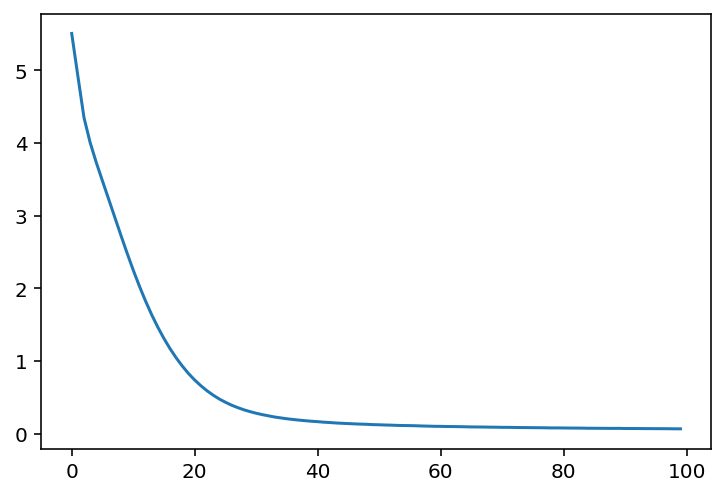

In [23]:
import matplotlib.pyplot as plt


plt.plot(np.arange(epochs), running_loss)

### ***Reload pre-trained Model***

In [16]:
loaded = MusicEmbeddingBaseline(embedding_size=50, hidden_size=512, post_embedding=128, vocab_size=train_ds.n, bidirectional=True)

In [17]:
loaded.load_state_dict(torch.load("embedded_model_fulldata_100_epochs.pt"))

<All keys matched successfully>

In [18]:
loaded

MusicEmbeddingBaseline(
  (embedding_layer): Embedding(2757, 50)
  (base_lstm): LSTM(50, 512, batch_first=True, bidirectional=True)
  (hidden_lstm): LSTM(1024, 1024, batch_first=True)
  (output_lstm): LSTM(1024, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=2757, bias=True)
)

### ***Evaluation***

In [24]:
### utils function that writes .midi files

def create_midi(prediction_output):
    from music21 import note, chord, instrument, stream
    offset = 0
    output_notes = []

        # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
            # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

            # increase offset each iteration so that notes do not stack
        offset += 0.25

    midi_stream = stream.Stream(output_notes)

    midi_stream.write("midi", fp="test_midi_fulldata_02.mid")

In [25]:
testing_model = loaded.eval().to(device)

start = np.random.randint(0, len(train_ds.data)-1)


pitchnames = sorted(set(item for item in train_ds.notes))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = train_ds.data[start]
window_size = train_ds.sequence_length
prediction_output = []

# doing auto regressive generation
for note_indx in tqdm(range(500)):
    prediction_input = pattern.view(1, len(pattern), 1).to(device)[:, note_indx:note_indx+window_size, :]

    prediction, _ = testing_model(prediction_input)
    # get prediction
    index = torch.argmax(prediction, dim=-1)
    
    # get note from prediction
    result = int_to_note[index.item()]
    # add to output
    prediction_output.append(result)
    # add predicted note to the input sequence
    pattern = torch.cat((pattern.cpu(), torch.unsqueeze(index.cpu(), dim=0)), dim=0)

    

create_midi(prediction_output)

100%|██████████| 500/500 [00:05<00:00, 90.81it/s]


In [26]:
prediction_output

['10.2.5',
 '10',
 '10.2.5',
 'B-2',
 '4.10',
 'B-2',
 '10.2.5',
 '9',
 '5.9.0',
 '9',
 'F2',
 '9',
 '5.9.0',
 '9',
 '5.9.0',
 '9',
 '7.9.0',
 '5.9',
 '7',
 '5.9',
 '7',
 '7',
 '5.9',
 '9',
 '7.10.2',
 '7.10.2',
 '7.10.2',
 '7.10.2',
 '7.10.2',
 '7.10.2',
 '7.10.2',
 'D5',
 'D3',
 '2.7',
 'G3',
 'D4',
 'G4',
 'G3',
 'G4',
 'B-4',
 'G3',
 'B-4',
 'B-4',
 'D4',
 'D4',
 'B-4',
 'B-3',
 'B-4',
 'C4',
 'B-4',
 'C4',
 '0.4',
 'G3',
 '0.4',
 'C4',
 '0.4',
 'C4',
 '2',
 'C4',
 '2',
 'A3',
 'A3',
 '2',
 'A3',
 'D4',
 '5',
 'D4',
 '5',
 'D4',
 '5',
 'C4',
 '5',
 '9.0',
 '5',
 'E3',
 '9',
 'E3',
 '9',
 '7.0',
 '7.0',
 'C4',
 '5',
 'A3',
 '5',
 'E3',
 '9.0',
 'E3',
 '9.0',
 'A3',
 '5',
 '5.9',
 'G3',
 '5.9',
 'G3',
 '5.9',
 'G3',
 'G3',
 'A3',
 '5.9',
 '5.9',
 'F4',
 '5.9',
 'E4',
 'E4',
 'B4',
 'C5',
 'B4',
 'C5',
 '2.7',
 'A3',
 '2.7',
 'A3',
 '7.11',
 'D3',
 '2.7',
 'D3',
 'G3',
 'A3',
 'C4',
 'A3',
 'D4',
 'E4',
 'E4',
 'E4',
 'E4',
 '9.2',
 '9.2',
 '9.2',
 '9.2',
 'A3',
 '9.2',
 'A3',
 'A3',
